<a href="https://colab.research.google.com/github/YENSTDi/interview_testing_chinesemedicine/blob/main/Test3_NLP_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下載相關套件

In [ ]:
!pip install datasets
!pip install transformers

In [2]:
import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from torch.optim import AdamW

from sklearn.metrics import accuracy_score

# IMDB資料引入

In [3]:
dataset = load_dataset("imdb")
dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

# NLP模型

In [4]:
MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 
cls_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

# 定義Dataset格式，方便data loader存取

In [5]:
class MainData(Dataset):
  def __init__(self, data, tokenizer) -> None:
    super().__init__()
    self.tokenizer = tokenizer
    self.data = data
  
  def __getitem__(self, index):
    text = self.data['text'][index]
    label = self.data['label'][index]

    token = self.tokenizer(text, padding=True, truncation=True, max_length=512)

    input_ids = token['input_ids']
    attention_mask = token['attention_mask']
    label = torch.tensor(label)

    return (input_ids, attention_mask, label)
  
  def __len__(self):
    return len(self.data['text'])

# 定義每個batch輸出格式

In [6]:
def create_batch(datas):
  input_ids = [torch.Tensor(i[0]) for i in datas]
  attention_mask = [torch.Tensor(i[1]) for i in datas]
  
  if datas[0][2] is not None:
      labels = torch.stack([i[2] for i in datas])
  else:
      labels = None

  input_ids_tensors = pad_sequence(input_ids, batch_first=True)
  masks_tensors = pad_sequence(attention_mask, batch_first=True)

  input_ids_tensors   = input_ids_tensors.to(torch.long)
  masks_tensors     = masks_tensors.to(torch.long)
  
  return input_ids_tensors, masks_tensors, labels

# 評估

In [7]:
def eval(model, data_loader):
  loss = 0
  model.eval()
  prediction = None
  true = None

  with torch.no_grad():
    for index, data in enumerate(data_loader):
      input_ids, marks, label= [t.to("cuda:0") for t in data]
      
      output_loss = model(input_ids, marks, labels=label)
      loss += output_loss[0].item()

      output = model(input_ids, marks)
      logits = output[0]
      _, pred = torch.max(logits.data, 1)

      pred = pred.cpu()
      label = label.cpu()

      if prediction is None:
        prediction = pred
        true = label
      else:
        prediction = torch.cat((prediction, pred))
        true = torch.cat((true, label))

  loss = loss / len(data_loader)
  acc = accuracy_score(true, prediction)
  return acc, loss

# 設定訓練、驗證集大小

In [8]:
train_count = 700
val_count = 300

torch.random.manual_seed(16)
train_index = torch.randint(len(dataset['train']), (train_count,))
val_index = torch.randint(len(dataset['test']), (val_count,))

# 使用data loader解決GPU記憶體不足問題

In [9]:
train_dataset = MainData(dataset['train'][train_index], tokenizer)
val_dataset = MainData(dataset['test'][val_index], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, collate_fn=create_batch)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=create_batch)

# Fine-turning

In [10]:
device = 'cuda:0'
cls_model = cls_model.to(device)

optimizer = AdamW(cls_model.parameters(), lr=5e-5)
Train_loss = []
Val_loss = []
Train_acc = []
Val_acc = []

EPOCH = 5
for epoch in range(EPOCH):
  bts = 0
  for index, data in enumerate(train_loader):
    cls_model.train()
    input_ids, marks, label = [t.to(device) for t in data]
    
    optimizer.zero_grad()
    
    output = cls_model(input_ids, marks, labels=label)
    l = output[0]
    l.backward()
    optimizer.step()

    bts+=1
    stats = 'Epoch [%d/%d], Step [%d/%d], Batch-Loss: %.4f' % (epoch+1, EPOCH, bts, len(train_loader), l.item())
    print('\r' + stats, end="")
    sys.stdout.flush()

  
  train_acc, train_loss = eval(cls_model, train_loader)
  val_acc, val_loss = eval(cls_model, val_loader)
  Train_loss.append(train_loss)
  Val_loss.append(val_loss)
  Train_acc.append(train_acc)
  Val_acc.append(val_acc)

  stats = 'Epoch [%d/%d], Step [%d/%d], Train-Loss: %.4f, Val-Loss: %.4f, Train-Acc: %.4f, Val-Acc: %.4f' \
    % (epoch+1, EPOCH, bts, len(train_loader), train_loss, val_loss, train_acc, val_acc)
  print('\r' + stats)

Epoch [1/5], Step [44/44], Train-Loss: 0.1303, Val-Loss: 0.2549, Train-Acc: 0.9571, Val-Acc: 0.8900
Epoch [2/5], Step [44/44], Train-Loss: 0.0464, Val-Loss: 0.3802, Train-Acc: 0.9843, Val-Acc: 0.8700
Epoch [3/5], Step [44/44], Train-Loss: 0.0749, Val-Loss: 0.6409, Train-Acc: 0.9743, Val-Acc: 0.8500
Epoch [4/5], Step [44/44], Train-Loss: 0.0361, Val-Loss: 0.4222, Train-Acc: 0.9871, Val-Acc: 0.8667
Epoch [5/5], Step [44/44], Train-Loss: 0.0275, Val-Loss: 0.3794, Train-Acc: 0.9900, Val-Acc: 0.8900


# Loss變化圖

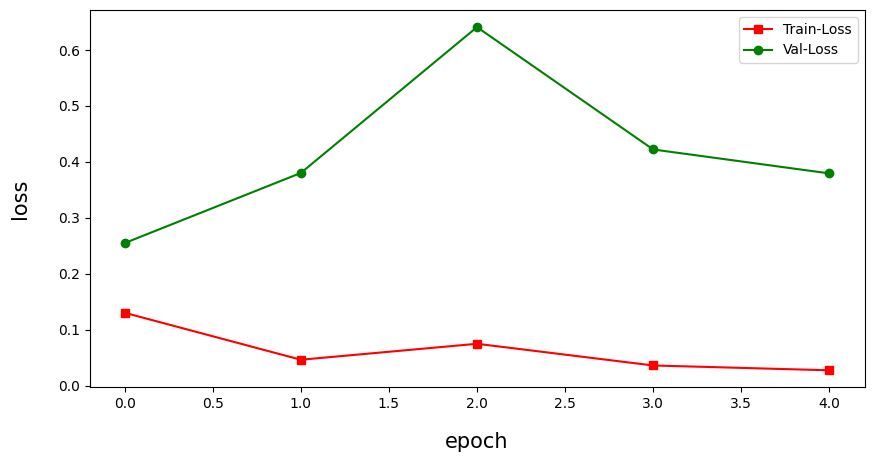

In [11]:
plt.figure(figsize=(10,5), dpi=100, linewidth = 2)
plt.plot(Train_loss, 's-', color='r', label="Train-Loss")   
plt.plot(Val_loss, 'o-', color='g', label="Val-Loss")    
plt.xlabel("epoch", fontsize=15, labelpad = 15)
plt.ylabel("loss", fontsize=15, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
plt.show()

# Accuracy變化圖

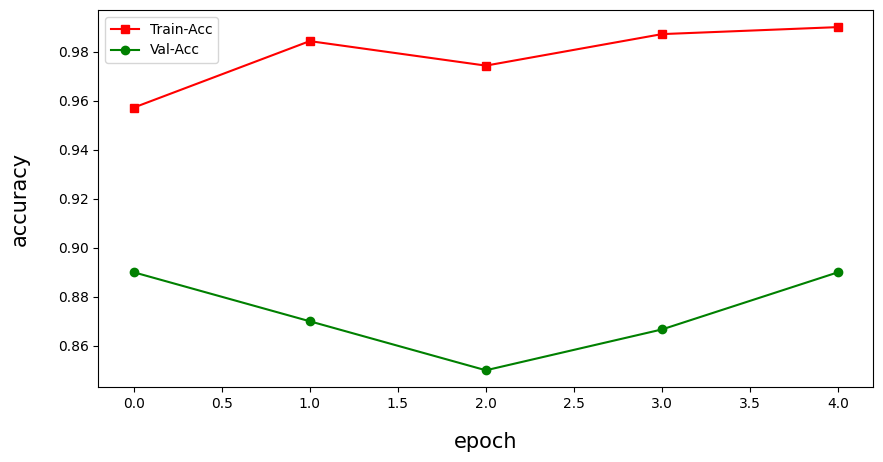

In [12]:
plt.figure(figsize=(10,5), dpi=100, linewidth = 2)
plt.plot(Train_acc, 's-', color='r', label="Train-Acc")   
plt.plot(Val_acc, 'o-', color='g', label="Val-Acc")    
plt.xlabel("epoch", fontsize=15, labelpad = 15)
plt.ylabel("accuracy", fontsize=15, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
plt.show()